# Clustering 3k PBMCs following a Seurat Tutorial

This started out (July 2017) with a demonstration that Scanpy would allow to reproduce most of Seurat's ([Satija *et al.*, 2015](https://doi.org/10.1038/nbt.3192)) clustering tutorial ([link](http://satijalab.org/seurat/pbmc3k_tutorial.html)), which we gratefully acknowledge. In the meanwhile, we have added and removed several pieces.

The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)).

In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
from scipy import sparse, io
from collections import Counter
import os.path
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/pbmc3k.h5ad'

/home/mada/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scanpy==1.3.3 anndata==0.6.13 numpy==1.14.2 scipy==1.0.0 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
sc.settings.set_figure_params(dpi=80)

## Load different datasets

## Brain Cidr

In [ ]:
df = pd.read_csv("input/brainCIDR/brainTags.csv", index_col = 0)

In [ ]:
df.columns.shape

In [ ]:
np.save('input/brainCIDR/cells.npy',  df.columns)
np.save('input/brainCIDR/genes.npy', df.index.values)
print(df.shape)
df.head()
m = sparse.csr_matrix(df.as_matrix())
io.mmwrite("input/brainCIDR/matrix.mtx", m)
del m, df

## Start here

In [3]:
%%time
path = 'input/brainCIDR/'
adata = sc.read(f'{path}matrix.mtx', cache=True).T  # transpose the data
adata.var_names = np.load(f'{path}/genes.npy')
adata.obs_names = np.load(f'{path}/cells.npy')

... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
CPU times: user 99.6 ms, sys: 35.8 ms, total: 135 ms
Wall time: 134 ms


In [4]:
adata.var_names.shape, adata.obs_names.shape

((22085,), (420,))

In [5]:
if os.path.isfile('input/brainCIDR/truth.pkl'):
    truth = pd.read_pickle('input/brainCIDR/truth.pkl')
else:
    truth = pd.read_csv("input/brainCIDR/truth.csv", index_col = 0)
    truth.set_index('colnames.brainTags.', inplace=True)
    truth['truth'] = truth['truth'].astype('category')
    truth['clusters'] = truth['truth'].cat.codes
    truth.to_pickle('input/brainCIDR/truth.pkl')
print(truth.shape)
# display(truth.head())
# truth.clusters.value_counts()

(420, 2)


In [6]:
# adata = sc.read_10x_mtx(
#     './data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Starting pipeline

In [7]:
adata.var_names_make_unique()

## Preprocessing

**Note:** In notebooks and jupyter lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

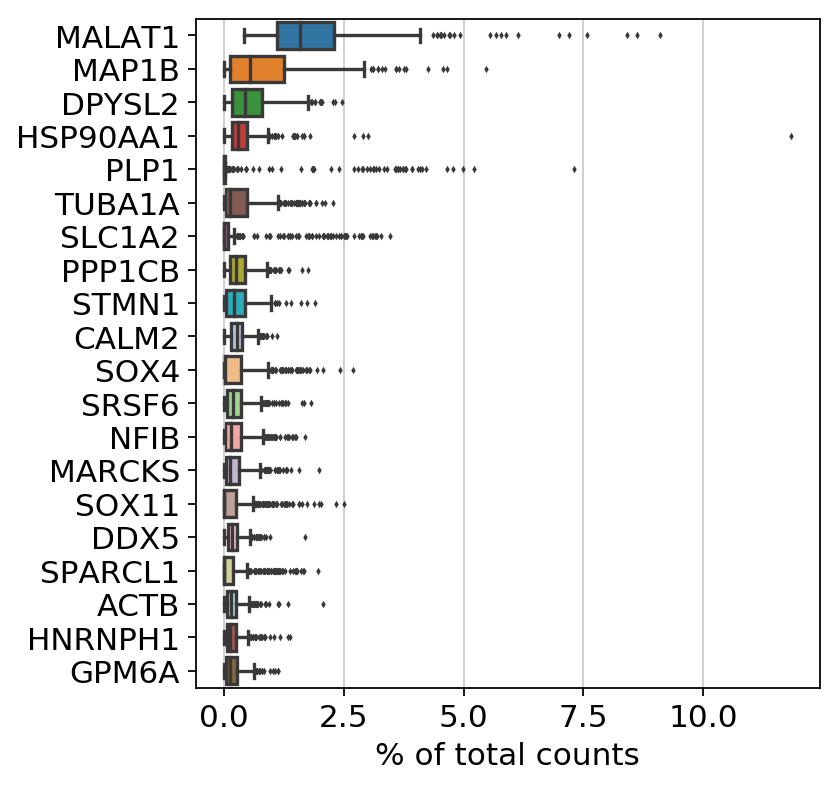

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering.

In [ ]:
# sc.pp.filter_cells(adata, min_genes=200)
# sc.pp.filter_genes(adata, min_cells=3)

Calculate and plot some quality control metrics, including propotion of mitochondrial expression. Note that you can also retrieve mitochondrial genes using `sc.queries.mitochondrial_genes_biomart('www.ensembl.org', 'mmusculus')`.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):
> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [ ]:
adata.var["mito"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, feature_controls=["mito"], inplace=True)

A violin plot of the computed quality measures.

In [ ]:
sc.pl.violin(adata, ['total_features_by_counts', 'total_counts', 'pct_counts_mito'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mito')
sc.pl.scatter(adata, x='total_counts', y='total_features_by_counts')

## Choose threshold based on dataset

In [ ]:
teta_total_features = 7500

Actually do the filtering.

In [ ]:
adata = adata[adata.obs['total_features_by_counts'] < teta_total_features, :]
adata = adata[adata.obs['pct_counts_mito'] < 5, :]

Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object returned by `sc.pp.log1p`.

In [9]:
adata.raw = sc.pp.log1p(adata, copy=True)

Per-cell normalize the data matrix $\mathbf{X}$. Many people would consider the normalized data matrix as the "relevant data" for visualization and differential testing (assessing feature importance). Until a common viewpoint is reached on this, the decision of what to consider "raw", is up to the user. We tend to recommend to use the normalized data for visualization and differential testing even though here, we use the non-normalized data for the sake of consistency with the Seurat tutorial.

In [10]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Identify highly-variable genes.

In [ ]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

Actually do the filtering.

In [ ]:
adata = adata[:, filter_result.gene_subset]

Logarithmize the data.

In [11]:
sc.pp.log1p(adata)

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mito'])

Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [ ]:
sc.pp.scale(adata, max_value=10)

Save the result.

In [ ]:
adata.write(results_file)

## PCA

Compute PCA and make a scatter plot.

In [12]:
sc.tl.pca(adata, svd_solver='arpack')

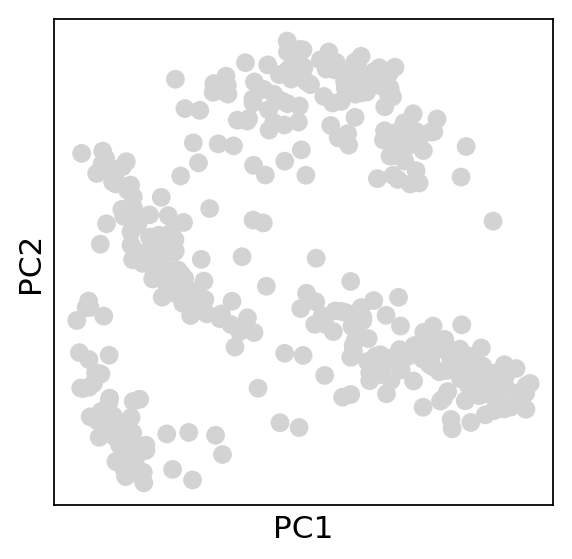

In [13]:
sc.pl.pca(adata)

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine. Seurat provides many more functions, here.

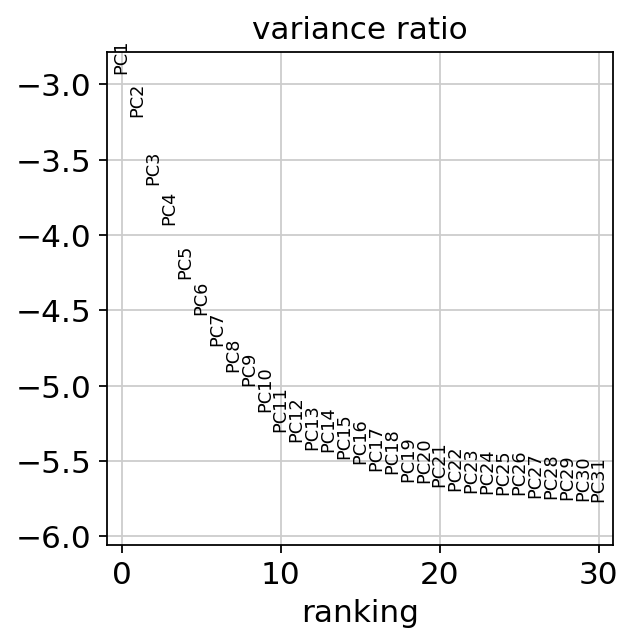

In [14]:
sc.pl.pca_variance_ratio(adata, log=True)

In [15]:
adata.write(results_file)

In [16]:
adata

AnnData object with n_obs × n_vars = 420 × 22085 
    obs: 'n_counts'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

In [17]:
adata = sc.read(results_file)

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [18]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:03.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


We now advertise visualizing the data using UMAP, see below. In particular, if you have large data, this will give you a notable speedup. Also, it is potentially more faithful to global topology: trajectories are better preserved.

In [19]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:01.80) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [20]:
# sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

As we set the `.raw` attribute of AnnData (a "frozen" state of the object at a point in the pipeline where we deemed the data "raw"), the previous plots showed the raw gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

In [21]:
# sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering the graph

As Seurat and many others, we recommend the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine *et al.* (2015)](https://doi.org/10.1016/j.cell.2015.05.047). Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [22]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.01) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


Plot the data with tSNE. Coloring according to clustering. Clusters agree quite well with the result of Seurat.

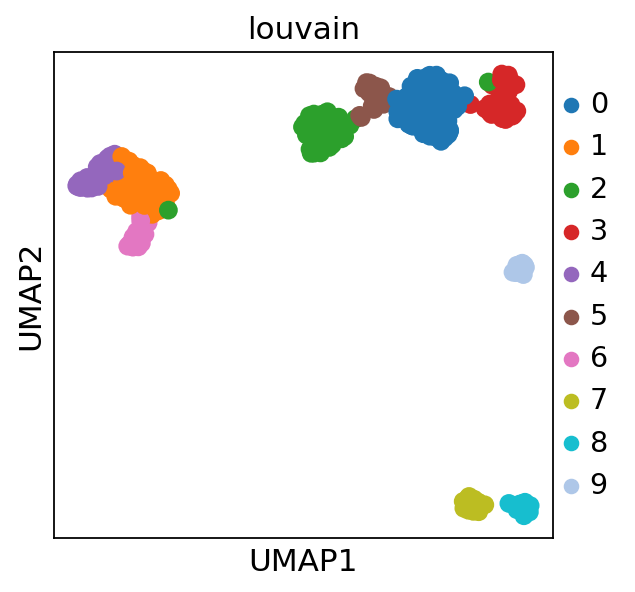

In [23]:
sc.pl.umap(adata
           , color=['louvain']
          )

In [24]:
adata.write(results_file)

In [25]:
clusters = adata.obs['louvain'].get_values()
clusters

array(['4', '1', '1', '1', '4', '1', '4', '1', '1', '4', '1', '4', '6',
       '4', '1', '4', '1', '1', '1', '1', '4', '1', '4', '4', '1', '4',
       '4', '4', '4', '1', '1', '4', '4', '4', '1', '4', '4', '4', '1',
       '4', '6', '1', '1', '1', '4', '4', '4', '1', '1', '1', '1', '4',
       '4', '1', '1', '1', '1', '4', '1', '4', '1', '1', '1', '1', '1',
       '1', '1', '1', '4', '1', '4', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '4', '1', '1', '1', '4', '1', '1', '1', '1', '1', '2',
       '2', '0', '2', '2', '3', '5', '3', '3', '0', '0', '5', '3', '2',
       '5', '0', '0', '0', '3', '2', '0', '5', '0', '3', '3', '0', '0',
       '2', '2', '2', '2', '7', '7', '2', '2', '0', '2', '0', '0', '7',
       '0', '5', '2', '5', '2', '2', '6', '6', '1', '6', '6', '6', '6',
       '6', '6', '1', '6', '6', '6', '6', '1', '6', '6', '6', '1', '6',
       '1', '6', '1', '1', '1', '6', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '4', '4', '1', '4', '6', '1', '1', '1', '4', '9

In [26]:
from sklearn.metrics.cluster import adjusted_rand_score

## There are less cells than in ground truth as some have been removed

In [27]:
adjusted_rand_score(truth[truth.index.isin(adata.obs_names)].clusters.tolist(), clusters)

0.7243541385191932

## Ground truth plotting on umap data

In [ ]:
umapCoord = adata.obsm['X_umap']

In [ ]:
import matplotlib.pyplot as plt
plt.ion()
plt.show()

In [ ]:
plt.scatter(umapCoord[:,0], umapCoord[:,1], c = truth[truth.index.isin(adata.obs_names)].clusters.tolist())

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. Here, we simply rank genes with a t test, which agrees quite well with Seurat.

For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before.

In [ ]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, save='.pdf')
adata.write(results_file)

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a Wilcoxon-Rank-Sum test is very similar.

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos *et al.* (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate ([Clark *et al.*, 2014](https://doi.org/10.1186/1471-2105-15-79)).

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

With the exception of IL7R, which is found only by the t-test at rank 17 but not by logistic regression, all marker genes are recovered using both approaches for ranking marker genes.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 |	CD8A |	CD8 T cells
4 |	GNLY, NKG7 | 	NK cells
5 |	FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 |	FCER1A, CST3 |	Dendritic Cells
7 |	PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference. Here, we added a few more genes.

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

Get a table with the scores and groups.

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(5)

Compare to a single cluster. 

In [ ]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [ ]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reread the examples that were computed by comparing to the rest of the groups.

In [ ]:
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='louvain')

Actually mark the cell types.

In [ ]:
new_cluster_names = [
    'CD4 T', 'CD14+ Monocytes',
    'B', 'CD8 T', 
    'NK', 'FCGR3A+ Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('louvain', new_cluster_names)

In [ ]:
sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

In [ ]:
sc.pl.dotplot(adata, marker_genes, groupby='louvain')

There is also a very compact violin plot.

In [ ]:
sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90, save='.pdf')

See more examples using heatmaps and annotions of the plots [here](https://gist.github.com/fidelram/2289b7a8d6da055fb058ac9a79ed485c).

During the course of this analysis, the AnnData accumlated the following annotations.

In [ ]:
adata

In [ ]:
adata.write(results_file)

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations.

In [ ]:
adata.X = None
adata.write('./write/pbmc3k_withoutX.h5ad')

If you want to export to "csv", you have the following options:

In [ ]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )